In [322]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import scipy.stats

In [731]:
simulations = 1000
bins = 100

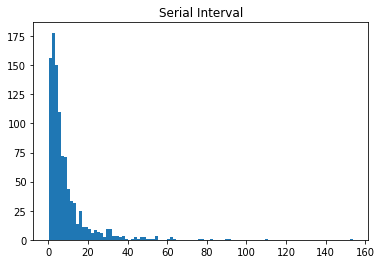

In [324]:
mean = 4.7
sd = 2.9
serial_interval = np.random.lognormal(math.log(mean), math.log(sd), simulations)

plt.hist(serial_interval, bins=bins)
plt.title("Serial Interval");

In [432]:
scipy.stats.lognorm.pdf(1.3, sd)

0.10538805446318376

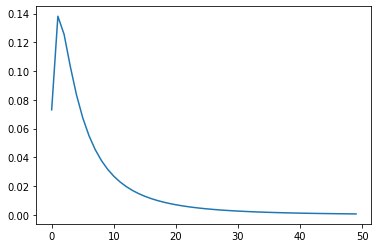

In [730]:
days = list(range(0, 50))

# From R implementation, discrete lognorm distribution
serial_intervals = [0.07304178, 0.1380941983, 0.1254991537, 0.1031686847, 0.0833675732, 0.0675321901,
0.0551452103, 0.0454561453, 0.0378228034, 0.0317515990, 0.0268743872,
0.0229180320, 0.0196790215, 0.0170044781, 0.0147784468, 0.0129120896,
0.0113366661, 0.0099984770, 0.0088551917, 0.0078731556, 0.0070253962,
0.0062901340, 0.0056496578, 0.0050894699, 0.0045976289, 0.0041642418,
0.0037810675, 0.0034412056, 0.0031388501, 0.0028690930, 0.0026277681,
0.0024113235, 0.0022167196, 0.0020413456, 0.0018829508, 0.0017395888,
0.0016095705, 0.0014914261, 0.0013838725, 0.0012857867, 0.0011961830,
0.0011141943, 0.0010390555, 0.0009700905, 0.0009066999, 0.0008483516,
0.0007945720, 0.0007449388, 0.0006990746, 0.0006566419, 0.0006173378]

plt.plot(days, [ serial_intervals[n] for n in days ], label='lognorm pdf');

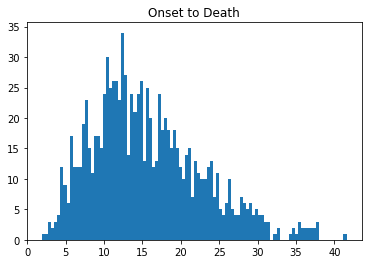

In [326]:
shape = 4.726
rate = 0.3151
onset_to_death = np.random.gamma(shape, rate, simulations) * 10

plt.hist(onset_to_death, bins=bins)
plt.title("Onset to Death");

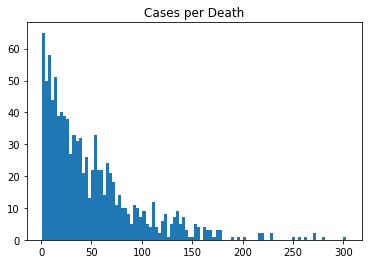

In [327]:
case_fatality_ratio = 0.02
cases_per_death = np.random.geometric(case_fatality_ratio, simulations)

plt.hist(cases_per_death, bins=bins)
plt.title("Cases per Death");

Formula for poison lambda at time t:

$$\lambda_t = \sum_{s = 1}^{t - 1} y_s w(t - s)$$

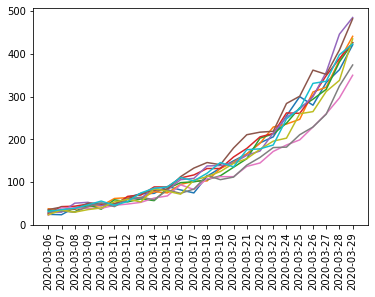

In [811]:
import datetime

reproduction_number = 2

def move_yyyy_mm_dd(dt, days):
    return (datetime.datetime.strptime(dt, "%Y-%m-%d") + datetime.timedelta(days=days)).strftime("%Y-%m-%d")

def diff_yyyy_mm_dd(dt1, dt2):
    (dt1-dt).days

# Example a single death
def simulate_one(death, simulations=50):
    probable_days_ago_onset = int(np.random.gamma(shape, rate) * 10)
    n_cases_per_day = np.random.geometric(case_fatality_ratio)
    onset_date = move_yyyy_mm_dd(death, -probable_days_ago_onset)
    
    incidences = {
        onset_date: n_cases_per_day
    }
    from_onset_to_today = (datetime.datetime.today() - datetime.datetime.strptime(onset_date, "%Y-%m-%d")).days + 1

    for t in range(1, from_onset_to_today):
        lambda_t = sum([ incidences[move_yyyy_mm_dd(onset_date, s)] * serial_intervals[min(t - s, 50)] for s in range(0, t) ])
        incidences_t = np.random.poisson(lambda_t * reproduction_number, simulations)
        incidences[move_yyyy_mm_dd(onset_date, t)] = incidences_t

    del incidences[onset_date]
    return incidences
    

n_simulations = 10
incidences = simulate_one("2020-03-24", simulations=n_simulations)
days = list(incidences.keys())
for i in range(0, n_simulations):
    line = [ incidences[x][i] for x in days ]
    plt.plot(days, line)
    
plt.xticks(rotation=90);

In [812]:
def simulate_multiple(deaths):
    projections = [ simulate_one(death) for death in deaths ]
    result = {}
    for projection in projections:
        for key in projection.keys():
            if key not in result:
                result[key] = projection[key]
            else:
                result[key] = np.array(result[key]) + np.array(projection[key])
            
    return result
        
def sorted_collection(collection):
    return collections.OrderedDict(sorted(collection.items()))
    
sorted_collection(simulate_multiple(["2020-03-24", "2020-03-26", "2020-03-28"]))

OrderedDict([('2020-02-24',
              array([ 5,  3,  3,  6,  5,  6,  7, 10,  5,  4,  9,  5,  8,  7,  5, 10,  5,
                      5,  7,  9,  7, 11, 12,  7,  5,  7,  8,  7,  9,  9,  8, 10,  9,  9,
                      6,  7,  5,  6,  5,  9,  4,  7,  7,  6, 10,  6,  4,  9,  6, 11])),
             ('2020-02-25',
              array([ 5,  5,  7, 10, 10,  8, 10, 10, 10,  9, 10, 10,  8,  8,  5,  8,  9,
                      8, 11, 13,  3, 11, 15,  4,  7,  4,  8,  7,  7,  2,  7,  9,  9, 11,
                      7,  5,  7,  6,  7, 10, 12, 11,  4, 15, 11,  6,  5, 10,  5,  5])),
             ('2020-02-26',
              array([ 7,  5,  9,  6,  8, 10, 10, 11,  8,  5,  2, 12,  7, 17,  9,  8, 10,
                      8, 12, 10, 10,  7, 11,  5,  5,  6,  7,  5,  8,  6,  6,  9, 14, 13,
                     11, 11,  7, 12,  7, 12,  9,  5, 10,  9, 13, 10,  2, 13,  4,  9])),
             ('2020-02-27',
              array([13,  8,  4,  7,  7, 13, 14, 11,  9, 10, 12, 11,  9, 15,  7,  9,  9,
 

In [844]:
def simulate_multiple_many_times(deaths, trajectories_simulations):
    projections = [ simulate_multiple(deaths) for _ in range(0, trajectories_simulations) ]
    result = {}
    for projection in projections:
        for key in projection.keys():
            if key not in result:
                result[key] = projection[key]
            else:
                result[key] = np.concatenate([result[key], projection[key]])
    return result
    
simulations = simulate_multiple_many_times(["2020-03-24", "2020-03-26", "2020-03-28"], trajectories_simulations=100)
simulations["2020-03-29"][0:5]

array([238, 161, 245, 278, 153])

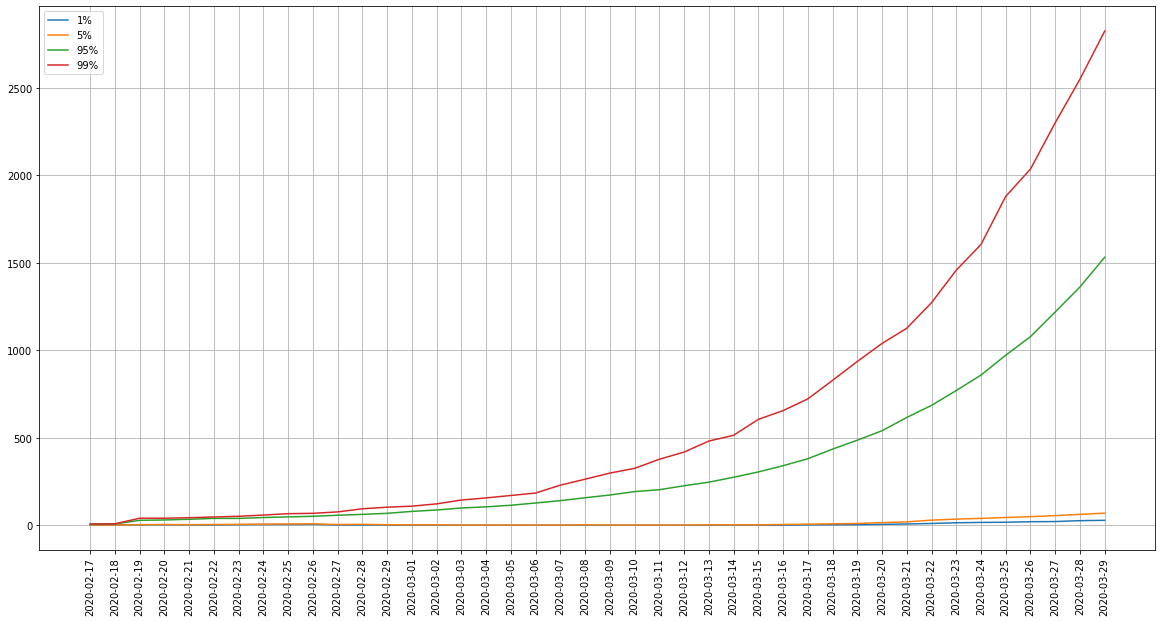

In [849]:
import collections

def map_percentiles(simulations):
    percentiles = {}
    for key in simulations.keys():
        pcts = np.percentile(simulations[key], [1, 5, 95, 100])
        percentiles[key] = { 1: pcts[0], 5: pcts[1], 95: pcts[2], 100: pcts[3] }
    return percentiles

def plot_simulations(simulations):
    cases = sorted_collection(map_percentiles(simulations))
    xs = [ key for key in cases.keys() ]
    ys = [ list(cases[key].values()) for key in cases.keys() ]
    plt.figure(figsize=(20, 10))
    plt.plot(xs, ys)
    plt.xticks(rotation=90)
    plt.grid()
    plt.legend(["1%", "5%", "95%", "99%"])
    plt.show()

plot_simulations(simulations)

In [850]:
df = pd.read_csv("caso.csv")
df.head()

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,2020-03-28,RO,NaN,state,6,0.0,8,True,1777225.0,11.0,0.33760,NaN
1,2020-03-27,RO,NaN,state,6,0.0,7,False,1777225.0,11.0,0.33760,NaN
2,2020-03-26,RO,NaN,state,6,0.0,6,False,1777225.0,11.0,0.33760,NaN
3,2020-03-25,RO,NaN,state,5,0.0,5,False,1777225.0,11.0,0.28134,NaN
4,2020-03-24,RO,NaN,state,5,0.0,4,False,1777225.0,11.0,0.28134,NaN


In [851]:
states_with_death = df[(df.deaths > 0) & (df.place_type == "state")]
states_with_death = list(np.unique(states_with_death["state"])) + ["BR"]
states_with_death 

['AM', 'CE', 'DF', 'GO', 'PE', 'PI', 'PR', 'RJ', 'RS', 'SC', 'SP', 'BR']

In [852]:
def multiply_dates_per_deaths(deaths_df):
    total_deaths = 0
    sorted_df = deaths_df.sort_values(by=['date'])
    dates = []
    for date in sorted_df.date:
        new_deaths = int(sorted_df[(sorted_df.date == date)].deaths) - total_deaths
        dates += [date] * new_deaths
        total_deaths += new_deaths
    return dates

deaths_rj = df[(df.deaths > 0) & (df.place_type == "state") & (df.state == "RJ")]
multiply_dates_per_deaths(deaths_rj)

['2020-03-19',
 '2020-03-19',
 '2020-03-21',
 '2020-03-23',
 '2020-03-24',
 '2020-03-24',
 '2020-03-25',
 '2020-03-25',
 '2020-03-26',
 '2020-03-27',
 '2020-03-28',
 '2020-03-28',
 '2020-03-28']

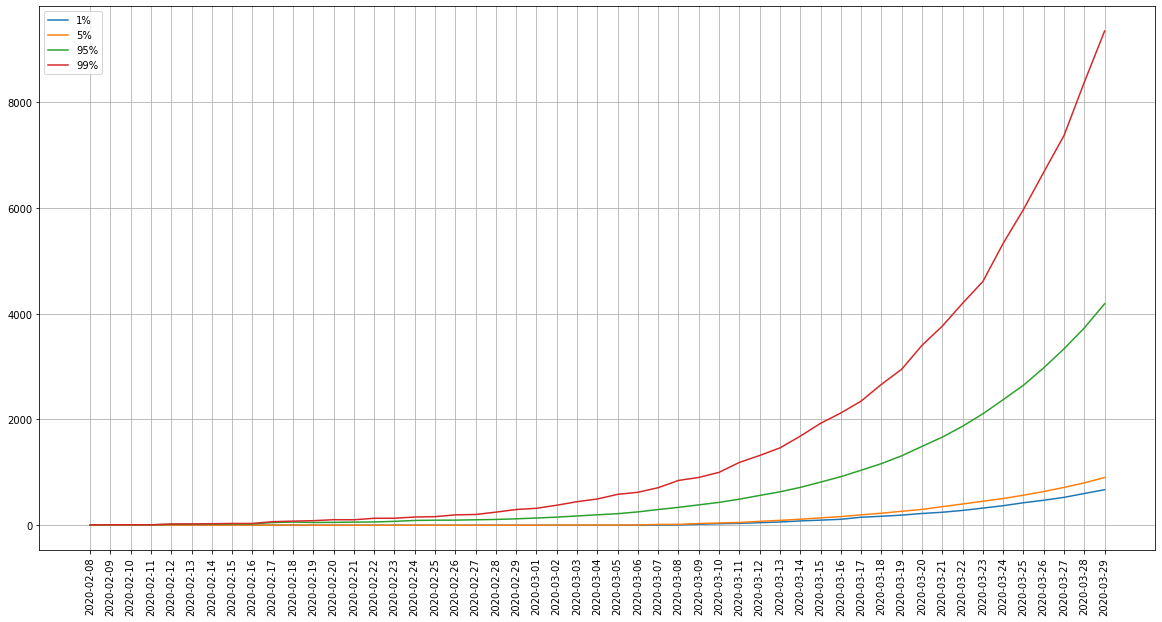

array([2813, 2491, 2378, ..., 1499, 1675, 1330])

In [853]:
state = "RJ"
deaths_state = df[(df.deaths > 0) & (df.place_type == "state") & (df.state == state)]    
dates = multiply_dates_per_deaths(deaths_state)
simulations = simulate_multiple_many_times(dates, trajectories_simulations=100)
plot_simulations(simulations)
simulations["2020-03-29"]

Simulating AM


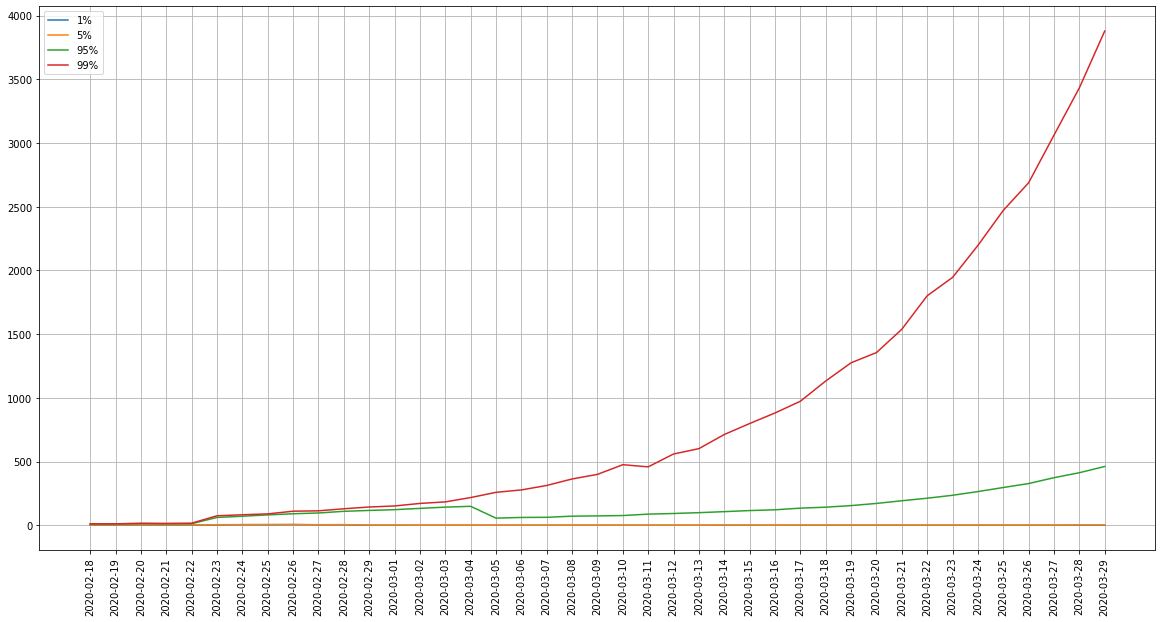

Simulating CE


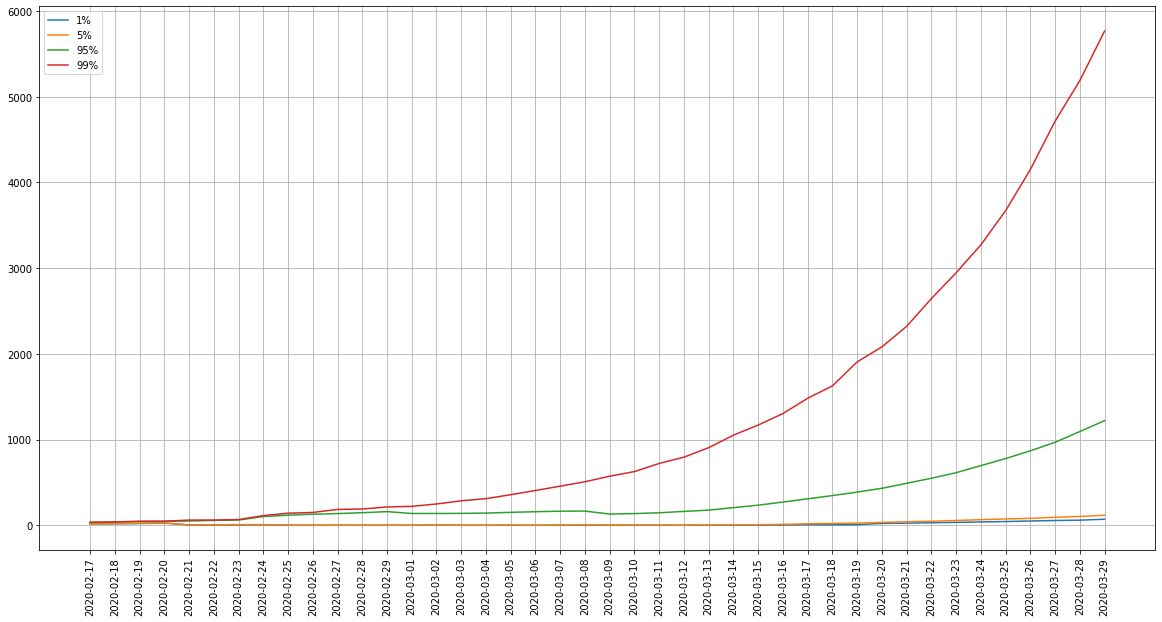

Simulating DF


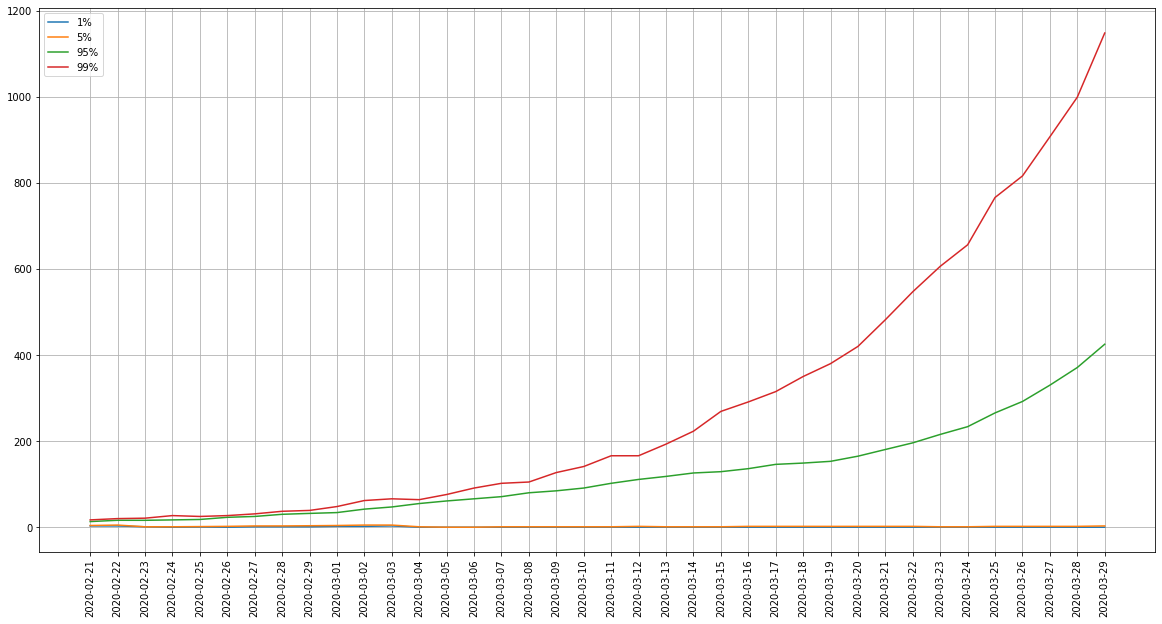

Simulating GO


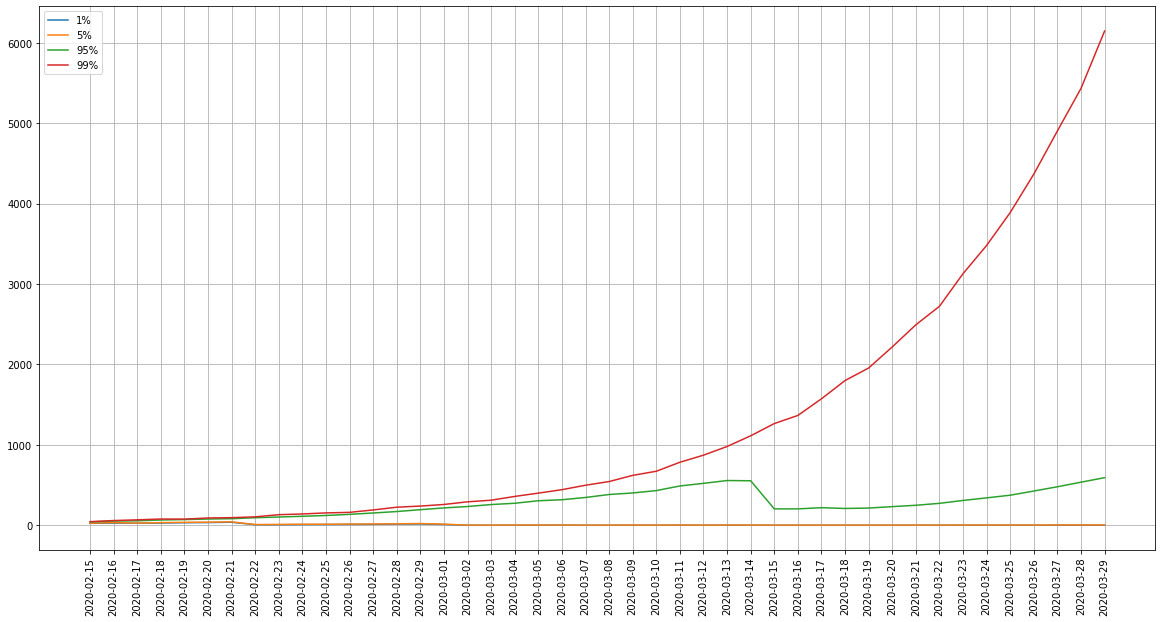

Simulating PE


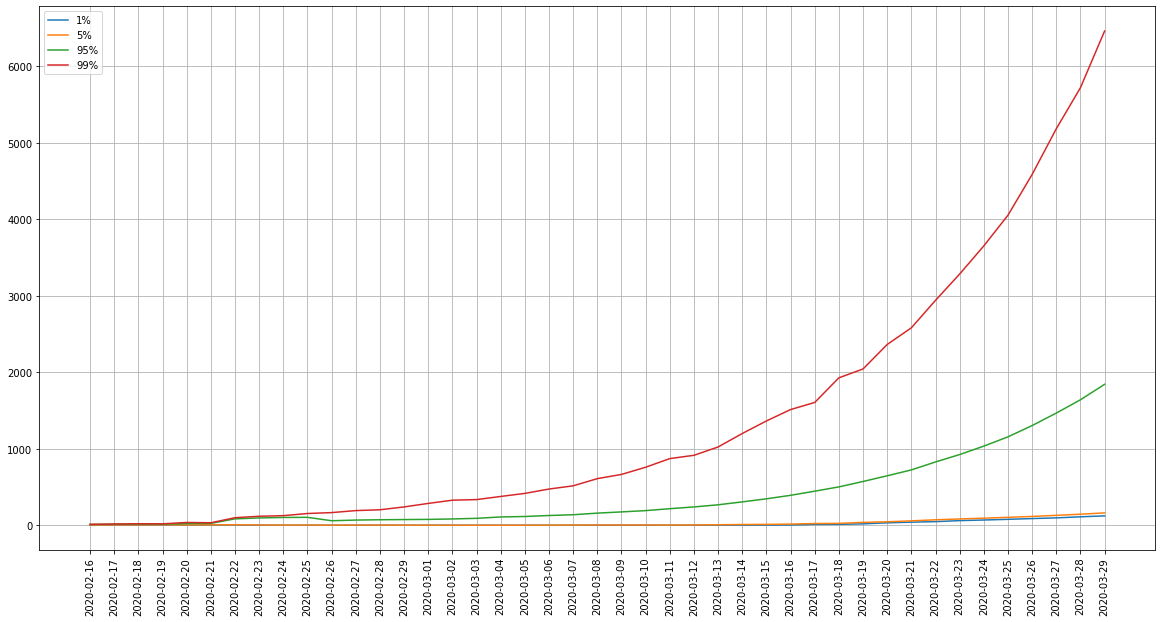

Simulating PI


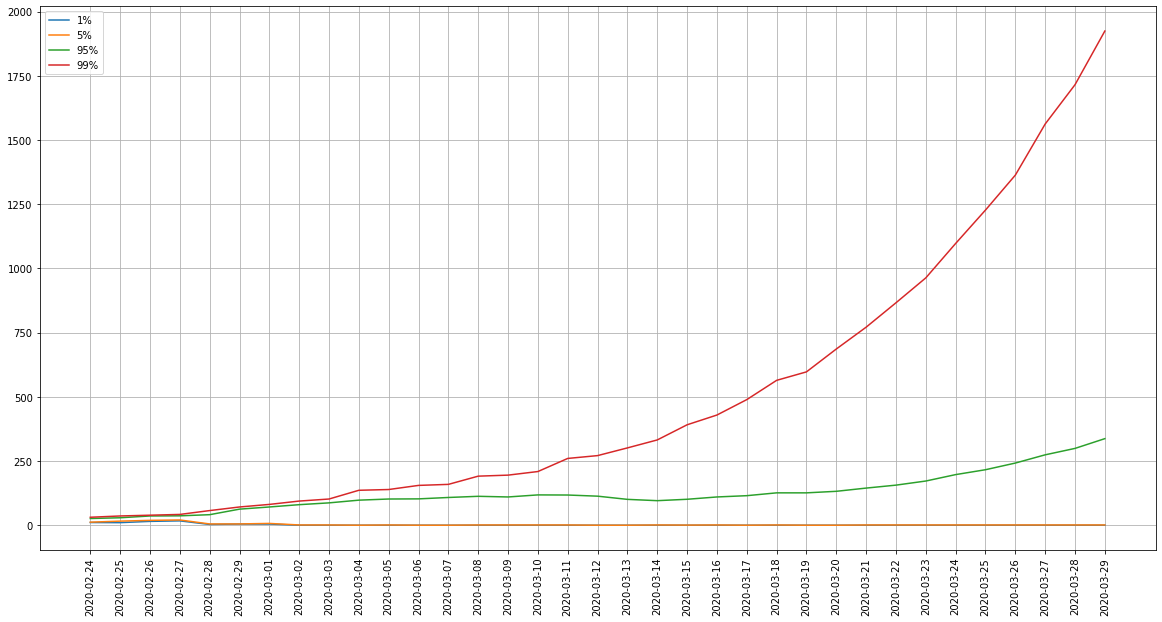

Simulating PR


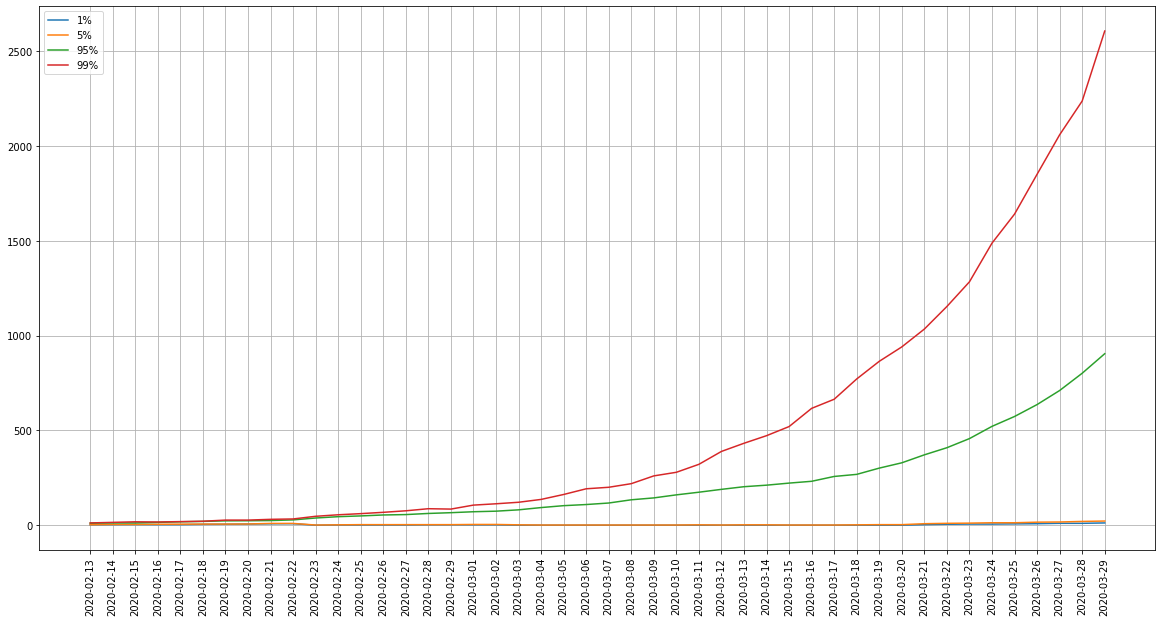

Simulating RJ


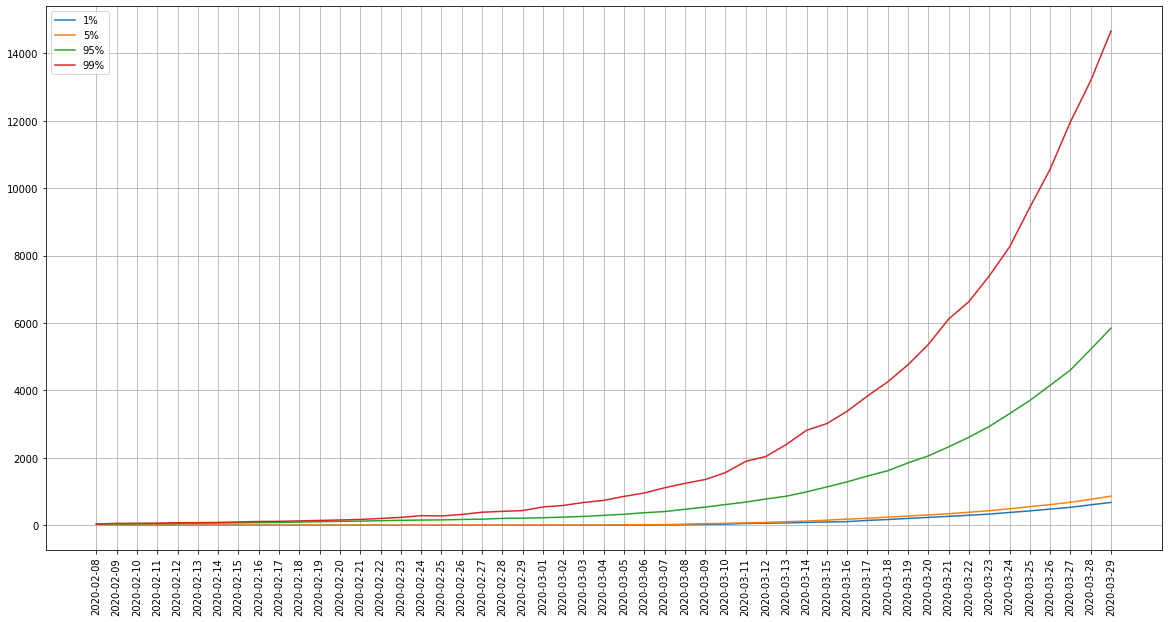

Simulating RS


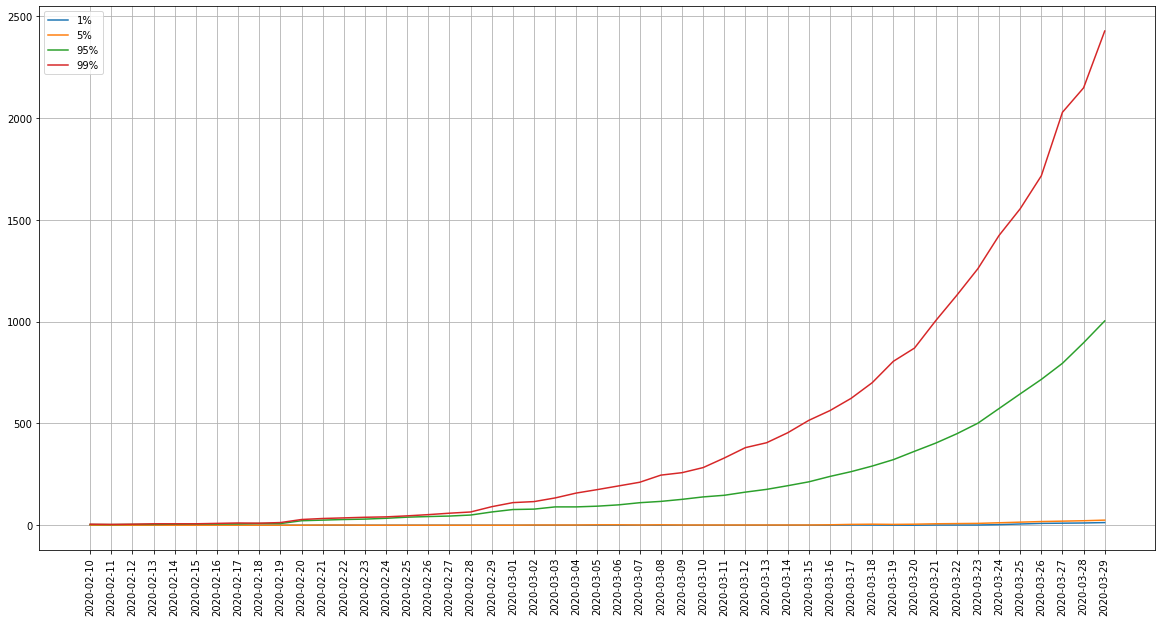

Simulating SC


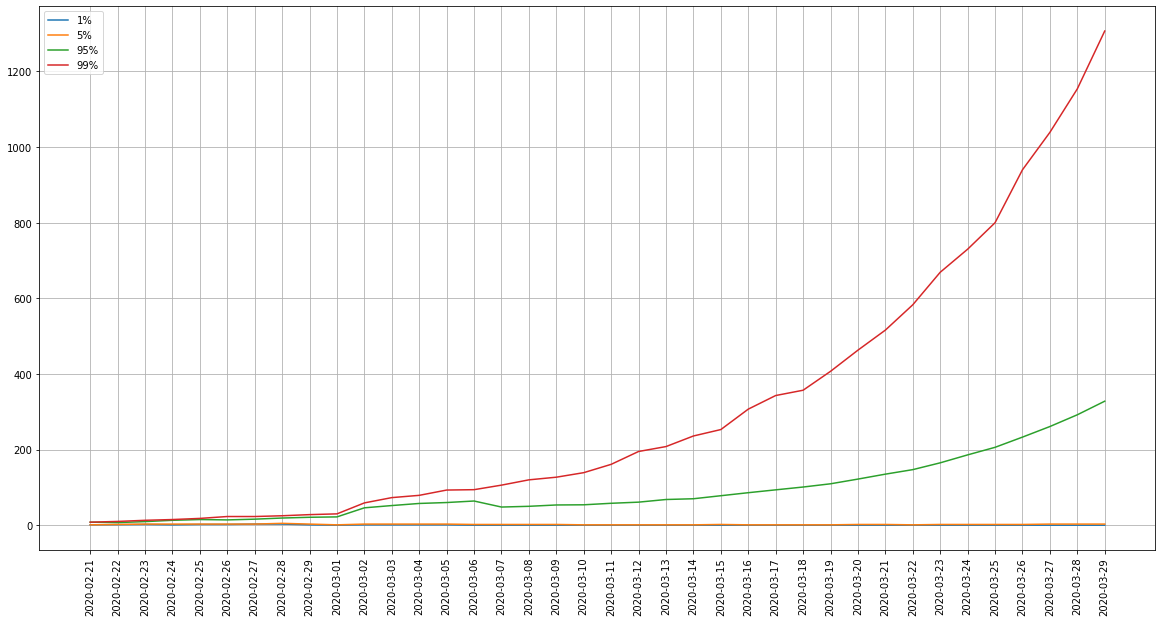

Simulating SP


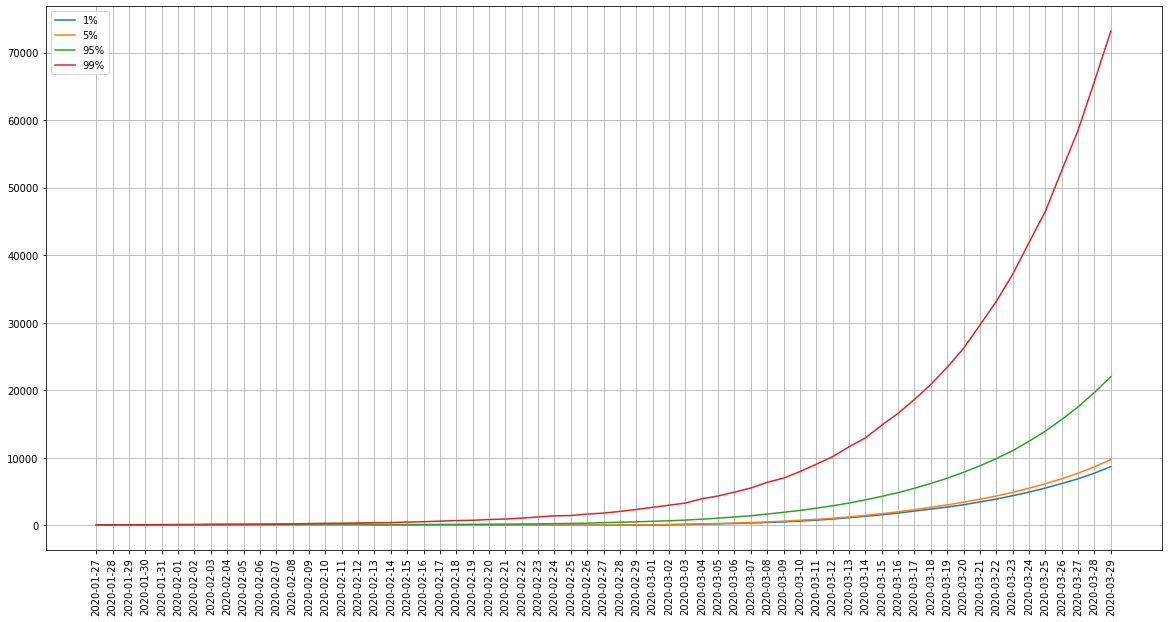

Simulating BR


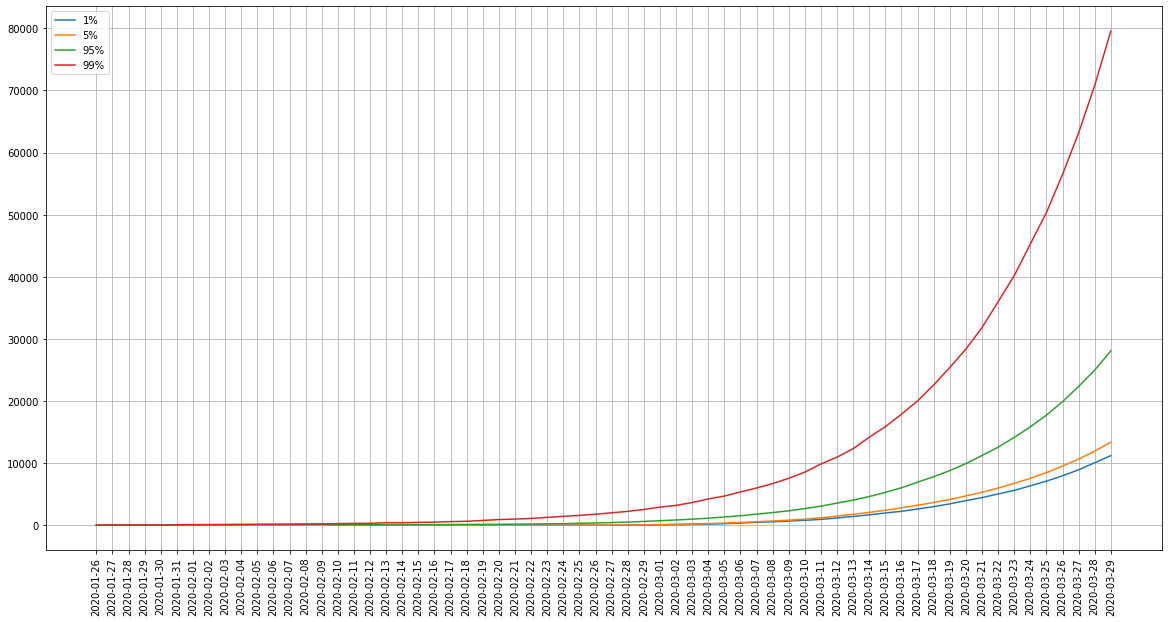

{'AM': OrderedDict([('2020-02-18',
               {1: 1.0, 5: 2.0, 95: 9.549999999999997, 100: 11.0}),
              ('2020-02-19', {1: 1.98, 5: 3.45, 95: 11.0, 100: 11.0}),
              ('2020-02-20', {1: 2.0, 5: 3.0, 95: 13.0, 100: 15.0}),
              ('2020-02-21', {1: 1.49, 5: 3.0, 95: 12.0, 100: 14.0}),
              ('2020-02-22',
               {1: 1.98, 5: 3.0, 95: 12.049999999999997, 100: 16.0}),
              ('2020-02-23', {1: 2.0, 5: 4.0, 95: 61.0, 100: 74.0}),
              ('2020-02-24',
               {1: 4.0, 5: 5.0, 95: 70.54999999999998, 100: 82.0}),
              ('2020-02-25', {1: 3.49, 5: 6.0, 95: 81.0, 100: 89.0}),
              ('2020-02-26', {1: 4.49, 5: 6.0, 95: 90.0, 100: 110.0}),
              ('2020-02-27', {1: 3.0, 5: 4.0, 95: 96.0, 100: 113.0}),
              ('2020-02-28',
               {1: 3.0, 5: 5.0, 95: 109.04999999999998, 100: 129.0}),
              ('2020-02-29',
               {1: 0.0, 5: 1.0, 95: 116.04999999999995, 100: 143.0}),
             

In [855]:
result = {}
for state in states_with_death:
    print("Simulating", state)
    if state == "BR":
        deaths_state = df[(df.deaths > 0) & (df.place_type == "state")]
        deaths_state = deaths_state[["date", "deaths"]].groupby(['date']).sum().reset_index()
    else:
        deaths_state = df[(df.deaths > 0) & (df.place_type == "state") & (df.state == state)]
        
    dates = multiply_dates_per_deaths(deaths_state)
    simulations = simulate_multiple_many_times(dates, trajectories_simulations=100)
    plot_simulations(simulations)
    sorted_percentiles = sorted_collection(map_percentiles(simulations))
    result[state] = sorted_percentiles
        
result

In [856]:
import json
with open('result.json', 'w') as f:
    json.dump(result, f)

### Trying the same with PyMC3, you can ignore below this line for now

$$\lambda_t = \sum_{s = 1}^{t - 1} y_s w(t - s)$$

In [472]:
death = "2020-03-24"
with pm.Model():
    #serial_interval = pm.Lognormal('serial_interval', mu=math.log(mean), sigma=math.log(sd))
#     onset_to_death = pm.Gamma('onset_to_death', alpha=shape, beta=rate)
    onset_to_death = int(np.random.gamma(shape, rate) * 10)
    cases_per_death = pm.Geometric('cases_per_death', p=case_fatality_ratio)
    onset_date = move_yyyy_mm_dd(death, -onset_to_death)
    incidences = {
        onset_date: pm.Deterministic("incidences_" + onset_date, cases_per_death)
    }

    for t in range(1, onset_to_death):
        s_sum = None
        for s in range(0, t):
            incidences_s = incidences[move_yyyy_mm_dd(onset_date, s)]
#             serial_interval_t_s = pm.Lognormal('serial_interval_' + str(t) + "_" + str(s), mu=math.log(t - s), sigma=math.log(sd))
            serial_interval_t_s = serial_intervals[t - s]
            y_times_w_t_s = incidences_s * serial_interval_t_s #pm.Deterministic("y_times_w_" + t + "_" + s, incidences_s * serial_interval_t_s)
            if s_sum is None:
                s_sum = y_times_w_t_s
            else:
                s_sum += y_times_w_t_s
        lambda_t = pm.Deterministic("lambda_" + str(t), s_sum * reproduction_number)
        
        date = move_yyyy_mm_dd(onset_date, t)
        incidences_t = pm.Poisson("incidences_" + date, mu=lambda_t)

        incidences[date] = incidences[move_yyyy_mm_dd(onset_date, t - 1)] + incidences_t
#         incidences[date] = incidences_t
    
    trace = pm.sample(10_000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [incidences_2020-03-23]
>Metropolis: [incidences_2020-03-22]
>Metropolis: [incidences_2020-03-21]
>Metropolis: [incidences_2020-03-20]
>Metropolis: [incidences_2020-03-19]
>Metropolis: [incidences_2020-03-18]
>Metropolis: [incidences_2020-03-17]
>Metropolis: [incidences_2020-03-16]
>Metropolis: [cases_per_death]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [01:08<00:00, 304.99draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [488]:
# trace.varnames

for i in range(1,9):
    print("lambda_" + str(i), np.mean(trace["lambda_" + str(i)]))

lambda_1 2.97519588685053
lambda_2 6.14660403511225
lambda_3 10.234331225188543
lambda_4 16.12204151682292
lambda_5 24.907981659777725
lambda_6 38.311029896582504
lambda_7 58.819098037242206
lambda_8 90.30221086955925


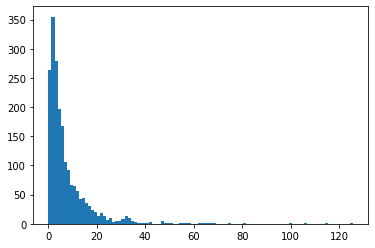

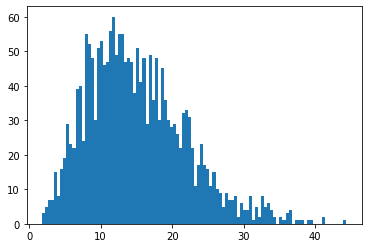

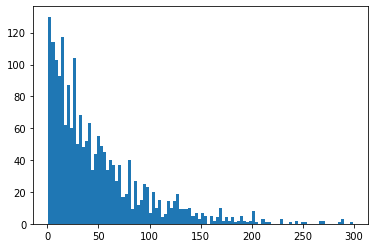

In [298]:
plt.hist(trace["serial_interval"], bins=bins)
plt.show()
plt.hist(trace["onset_to_death"], bins=bins)
plt.show()
plt.hist(trace["cases_per_death"], bins=bins)
plt.show()